
# 🎯 Objetivo: Detectar toxicidad con datos aumentados

## 📋 Estrategia:
### - Eliminar columnas desbalanceadas
### - Aplicar Data Augmentation con traducción
### - Preprocesar texto eficientemente
### - Entrenar XGboost

In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Procesamiento de texto
import re
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score 
import xgboost as xgb

# Para augmentación simple
import random
from textblob import TextBlob

# Persistencia
import pickle
from datetime import datetime

# Configuración
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

c:\Users\Marie\Desktop\IAe\Proyectos\PX-G1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cargar datos y análisis inicial

In [2]:

df = pd.read_csv('../data/youtoxic_english_1000.csv')
print(f"✅ Dataset original: {df.shape[0]} filas, {df.shape[1]} columnas")

# Columnas de toxicidad
columnas_toxicidad = ['IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 
                      'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 
                      'IsHomophobic', 'IsReligiousHate', 'IsRadicalism']



✅ Dataset original: 1000 filas, 15 columnas


# 2. Identificar y eliminar columnas desbalanceadas

In [3]:
print("\n🔍 Analizando balance de columnas...")

# Calcular balance
balance = {}
UMBRAL = 5.0  # 5% mínimo

for col in columnas_toxicidad:
    porcentaje = (df[col].sum() / len(df)) * 100
    balance[col] = porcentaje
    estado = "✅ Mantener" if porcentaje >= UMBRAL else "❌ Eliminar"
    print(f"{col:20} -> {porcentaje:5.1f}% {estado}")

# Seleccionar solo columnas balanceadas
columnas_mantener = [col for col in columnas_toxicidad if balance[col] >= UMBRAL]
columnas_eliminar = [col for col in columnas_toxicidad if balance[col] < UMBRAL]

print(f"\n📊 Resumen:")
print(f"   - Columnas a mantener: {len(columnas_mantener)}")
print(f"   - Columnas a eliminar: {len(columnas_eliminar)}")

# Crear etiqueta binaria solo con columnas balanceadas
df['toxic_binary'] = (df[columnas_mantener].sum(axis=1) > 0).astype(int)

# Eliminar columnas desbalanceadas del dataset
df = df.drop(columns=columnas_eliminar)

print(f"\n✅ Nueva distribución de toxicidad:")
print(df['toxic_binary'].value_counts())
print(f"Porcentaje tóxico: {df['toxic_binary'].mean()*100:.1f}%")


🔍 Analizando balance de columnas...
IsAbusive            ->  35.3% ✅ Mantener
IsThreat             ->   2.1% ❌ Eliminar
IsProvocative        ->  16.1% ✅ Mantener
IsObscene            ->  10.0% ✅ Mantener
IsHatespeech         ->  13.8% ✅ Mantener
IsRacist             ->  12.5% ✅ Mantener
IsNationalist        ->   0.8% ❌ Eliminar
IsSexist             ->   0.1% ❌ Eliminar
IsHomophobic         ->   0.0% ❌ Eliminar
IsReligiousHate      ->   1.2% ❌ Eliminar
IsRadicalism         ->   0.0% ❌ Eliminar

📊 Resumen:
   - Columnas a mantener: 5
   - Columnas a eliminar: 6

✅ Nueva distribución de toxicidad:
toxic_binary
0    538
1    462
Name: count, dtype: int64
Porcentaje tóxico: 46.2%


# 3. Preprocesamiento de texto

In [4]:
print("\n🧹 Preparando funciones de preprocesamiento...")

# Inicializar herramientas
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto(texto):
    """Limpieza rápida y eficiente del texto"""
    if pd.isna(texto):
        return ""
    
    texto = str(texto).lower()
    texto = re.sub(r'@\w+|http\S+|www\S+', '', texto)  # URLs y menciones
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)  # Solo letras
    texto = ' '.join(texto.split())  # Espacios extras
    
    return texto

def procesar_texto(texto):
    """Procesamiento completo con lemmatización"""
    # Tokenizar
    palabras = word_tokenize(texto)
    
    # Filtrar stopwords y palabras cortas
    palabras = [lemmatizer.lemmatize(p) for p in palabras 
                if p not in stop_words and len(p) > 2]
    
    return ' '.join(palabras)


🧹 Preparando funciones de preprocesamiento...


# 4. Data augmentation

In [5]:
print("\n🌐 Configurando Data Augmentation...")

def augmentar_texto_avanzado(texto):
    """
    Aumenta datos usando técnicas que no requieren APIs externas.
    Genera múltiples variaciones del texto original.
    """
    variaciones = []
    
    # 1. Reemplazo de sinónimos comunes
    sinonimos = {
        'hate': ['despise', 'loathe', 'detest'],
        'stupid': ['dumb', 'idiotic', 'foolish', 'moronic'],
        'bad': ['terrible', 'awful', 'horrible'],
        'good': ['great', 'excellent', 'wonderful'],
        'idiot': ['fool', 'moron', 'imbecile'],
        'ugly': ['hideous', 'repulsive', 'disgusting'],
        'fat': ['obese', 'overweight', 'heavy'],
        'kill': ['murder', 'destroy', 'eliminate'],
        'die': ['perish', 'expire', 'pass away'],
        'trash': ['garbage', 'rubbish', 'waste'],
        'suck': ['terrible', 'awful', 'horrible'],
        'dumb': ['stupid', 'idiotic', 'brainless']
    }
    
    # Variación 1: Reemplazar sinónimos
    texto_sinonimos = texto.lower()
    for palabra, alternativas in sinonimos.items():
        if palabra in texto_sinonimos:
            for alternativa in alternativas[:2]:  # Usar máximo 2 sinónimos
                nuevo_texto = texto_sinonimos.replace(palabra, alternativa)
                if nuevo_texto != texto_sinonimos:
                    variaciones.append(nuevo_texto)
    
    # 2. Inserción de ruido controlado
    palabras = texto.split()
    if len(palabras) > 5:
        # Variación 2: Eliminar palabras no esenciales
        palabras_importantes = [p for p in palabras if len(p) > 3]
        if len(palabras_importantes) > 3:
            variaciones.append(' '.join(palabras_importantes))
        
        # Variación 3: Cambiar orden de frases
        if '.' in texto or '!' in texto or '?' in texto:
            import re
            frases = re.split(r'[.!?]+', texto)
            frases = [f.strip() for f in frases if f.strip()]
            if len(frases) > 1:
                random.shuffle(frases)
                variaciones.append('. '.join(frases) + '.')
    
    # 3. Paráfrasis simple usando TextBlob (sin traducción)
    try:
        blob = TextBlob(texto)
        # Cambiar tiempos verbales si es posible
        if blob.tags:
            texto_modificado = str(blob)
            # Intercambiar algunas palabras comunes
            intercambios = [
                ('you are', "you're"), ("you're", 'you are'),
                ('i am', "i'm"), ("i'm", 'i am'),
                ('do not', "don't"), ("don't", 'do not'),
                ('will not', "won't"), ("won't", 'will not')
            ]
            for original, reemplazo in intercambios:
                if original in texto_modificado.lower():
                    texto_modificado = texto_modificado.lower().replace(original, reemplazo)
                    if texto_modificado != texto.lower():
                        variaciones.append(texto_modificado)
                        break
    except:
        pass
    
    # 4. Agregar/quitar puntuación excesiva (común en comentarios tóxicos)
    if any(c in texto for c in ['!', '?', '...']):
        # Reducir puntuación
        texto_reducido = re.sub(r'[!]+', '!', texto)
        texto_reducido = re.sub(r'[?]+', '?', texto_reducido)
        texto_reducido = re.sub(r'\.{3,}', '...', texto_reducido)
        if texto_reducido != texto:
            variaciones.append(texto_reducido)
        
        # Aumentar puntuación (para comentarios tóxicos)
        texto_aumentado = texto.replace('!', '!!!')
        texto_aumentado = texto_aumentado.replace('?', '???')
        if texto_aumentado != texto:
            variaciones.append(texto_aumentado)
    
    # Eliminar duplicados y retornar
    return list(set(variaciones))[:3]  # Máximo 3 variaciones por texto


🌐 Configurando Data Augmentation...


# 5. Aplicar augmentation a comentarios tóxicos 

In [6]:
print("\n🔄 Aplicando Data Augmentation a comentarios tóxicos...")

# Separar comentarios tóxicos para aumentar
df_toxicos = df[df['toxic_binary'] == 1].copy()
df_no_toxicos = df[df['toxic_binary'] == 0].copy()

print(f"Comentarios tóxicos originales: {len(df_toxicos)}")
print(f"Comentarios no tóxicos: {len(df_no_toxicos)}")

# Aplicar augmentation
comentarios_aumentados = []
etiquetas_aumentadas = []
contador = 0

for idx, row in df_toxicos.iterrows():
    texto_limpio = limpiar_texto(row['Text'])
    
    # Generar variaciones
    variaciones = augmentar_texto_avanzado(texto_limpio)
    
    for variacion in variaciones:
        if variacion and len(variacion) > 10:  # Solo agregar si tiene contenido
            comentarios_aumentados.append(variacion)
            etiquetas_aumentadas.append(1)
            contador += 1
    
    # Mostrar progreso
    if idx % 50 == 0:
        print(f"   Procesados: {idx}/{len(df_toxicos)} - Generados: {contador} nuevos")

# Crear DataFrame con datos aumentados
df_aumentados = pd.DataFrame({
    'Text': comentarios_aumentados,
    'toxic_binary': etiquetas_aumentadas
})

print(f"\n✅ Comentarios tóxicos generados: {len(df_aumentados)}")

# Combinar datasets
df_final = pd.concat([
    df[['Text', 'toxic_binary']],
    df_aumentados
], ignore_index=True)

# Mezclar aleatoriamente
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n📊 Dataset final:")
print(f"   - Total comentarios: {len(df_final)}")
print(f"   - Tóxicos: {df_final['toxic_binary'].sum()}")
print(f"   - No tóxicos: {len(df_final) - df_final['toxic_binary'].sum()}")
print(f"   - Balance: {df_final['toxic_binary'].mean()*100:.1f}% tóxicos")


🔄 Aplicando Data Augmentation a comentarios tóxicos...
Comentarios tóxicos originales: 462
Comentarios no tóxicos: 538
   Procesados: 50/462 - Generados: 55 nuevos
   Procesados: 100/462 - Generados: 104 nuevos
   Procesados: 150/462 - Generados: 155 nuevos
   Procesados: 250/462 - Generados: 232 nuevos
   Procesados: 350/462 - Generados: 295 nuevos
   Procesados: 600/462 - Generados: 434 nuevos
   Procesados: 750/462 - Generados: 545 nuevos
   Procesados: 900/462 - Generados: 617 nuevos

✅ Comentarios tóxicos generados: 688

📊 Dataset final:
   - Total comentarios: 1688
   - Tóxicos: 1150
   - No tóxicos: 538
   - Balance: 68.1% tóxicos


# 6. Preprocesar el dataset

In [7]:
print("\n⏳ Preprocesando todos los textos...")

# Aplicar limpieza y procesamiento
df_final['texto_limpio'] = df_final['Text'].apply(limpiar_texto)
df_final['texto_procesado'] = df_final['texto_limpio'].apply(procesar_texto)

# Eliminar filas vacías
df_final = df_final[df_final['texto_procesado'].str.len() > 0]

print(f"✅ Textos procesados: {len(df_final)}")

# Guardar dataset procesado
df_final.to_csv('../data/dataset_toxicidad_aumentado.csv', index=False)
print("💾 Dataset guardado como: ../data/dataset_toxicidad_aumentado.csv")




⏳ Preprocesando todos los textos...
✅ Textos procesados: 1688
💾 Dataset guardado como: ../data/dataset_toxicidad_aumentado.csv


# 7. Visualización de datos

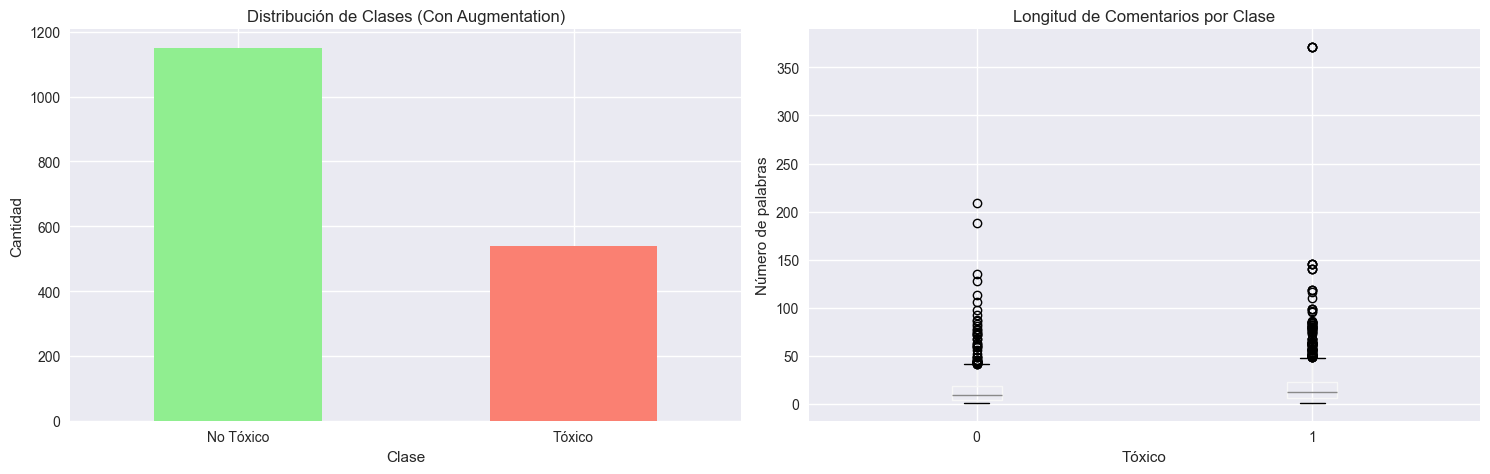

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Balance de clases
df_final['toxic_binary'].value_counts().plot(kind='bar', ax=axes[0], 
                                            color=['lightgreen', 'salmon'])
axes[0].set_title('Distribución de Clases (Con Augmentation)')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Cantidad')
axes[0].set_xticklabels(['No Tóxico', 'Tóxico'], rotation=0)

# Longitud de comentarios
df_final['longitud'] = df_final['texto_procesado'].str.split().str.len()
df_final.boxplot(column='longitud', by='toxic_binary', ax=axes[1])
axes[1].set_title('Longitud de Comentarios por Clase')
axes[1].set_xlabel('Tóxico')
axes[1].set_ylabel('Número de palabras')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Wordclouds comparativos


📊 WORDCLOUDS COMPARATIVOS
   • Comentarios tóxicos para WordCloud: 1150
   • Comentarios no tóxicos para WordCloud: 538
   • Palabras en corpus tóxico: 23197
   • Palabras en corpus no tóxico: 8785


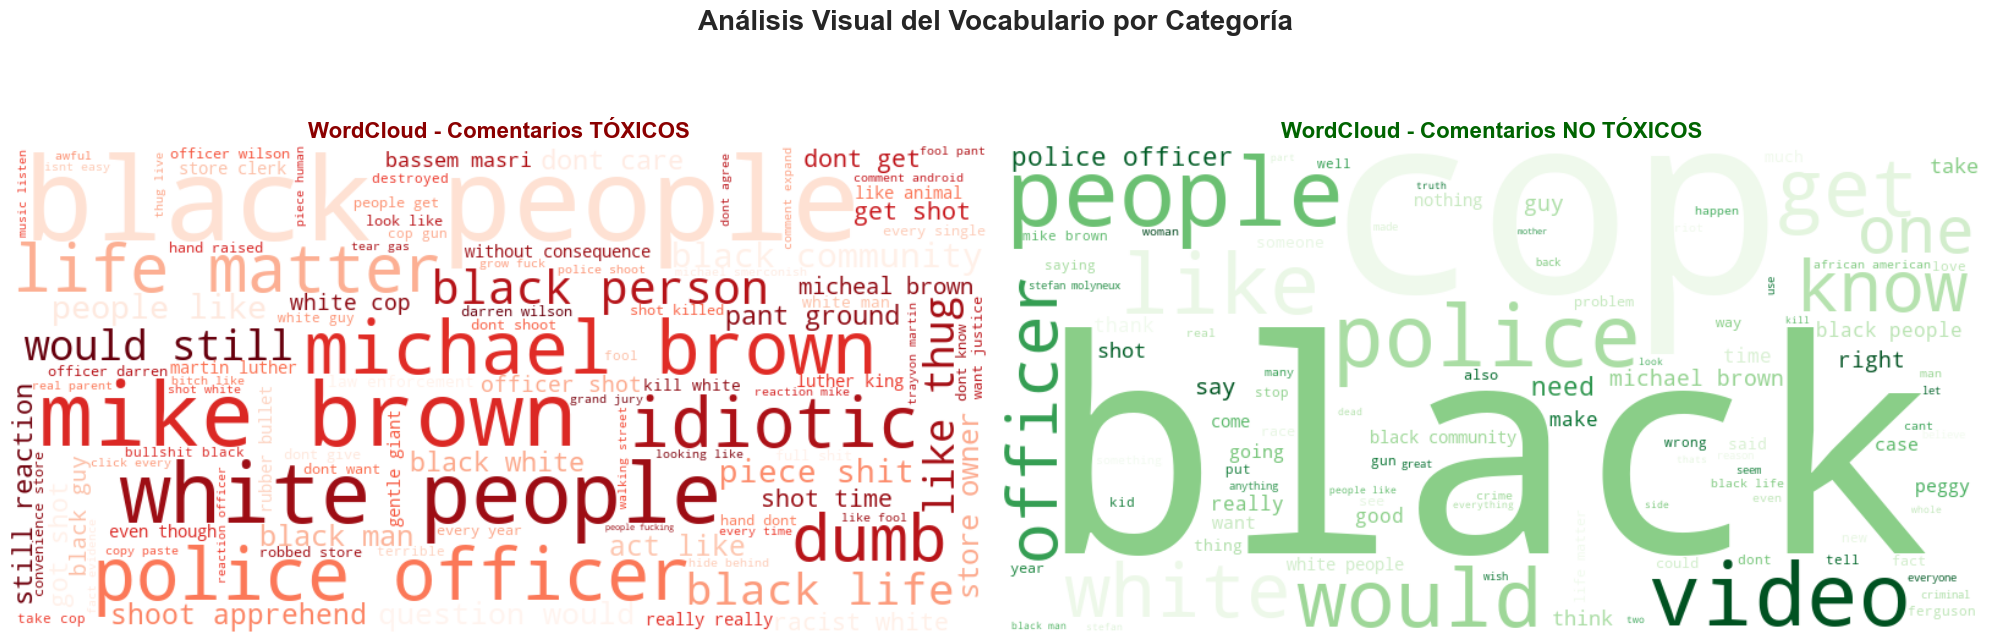

In [9]:
print("\n📊 WORDCLOUDS COMPARATIVOS")

# Separar textos por categoría usando los datos procesados
textos_toxicos = df_final[df_final['toxic_binary'] == 1]['texto_procesado']
textos_no_toxicos = df_final[df_final['toxic_binary'] == 0]['texto_procesado']

print(f"   • Comentarios tóxicos para WordCloud: {len(textos_toxicos)}")
print(f"   • Comentarios no tóxicos para WordCloud: {len(textos_no_toxicos)}")

# Combinar textos por categoría
texto_toxico_combinado = ' '.join(textos_toxicos.dropna())
texto_no_toxico_combinado = ' '.join(textos_no_toxicos.dropna())

print(f"   • Palabras en corpus tóxico: {len(texto_toxico_combinado.split())}")
print(f"   • Palabras en corpus no tóxico: {len(texto_no_toxico_combinado.split())}")

# Verificar que tenemos suficiente texto
if len(texto_toxico_combinado.split()) < 10:
    print("⚠️ Advertencia: Poco texto tóxico disponible para WordCloud")
if len(texto_no_toxico_combinado.split()) < 10:
    print("⚠️ Advertencia: Poco texto no tóxico disponible para WordCloud")

# Generar WordClouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Configuración común para ambos WordClouds
wordcloud_config = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'max_words': 100,
    'relative_scaling': 0.5,
    'stopwords': stop_words,  # Usar las mismas stopwords del preprocesamiento
    'collocation_threshold': 10
}

# WordCloud para comentarios tóxicos
if len(texto_toxico_combinado.strip()) > 0:
    wordcloud_toxico = WordCloud(
        **wordcloud_config,
        colormap='Reds'
    ).generate(texto_toxico_combinado)
    
    axes[0].imshow(wordcloud_toxico, interpolation='bilinear')
    axes[0].set_title('WordCloud - Comentarios TÓXICOS', fontweight='bold', fontsize=16, color='darkred')
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'No hay suficiente\ntexto tóxico', 
                ha='center', va='center', transform=axes[0].transAxes, fontsize=16)
    axes[0].set_title('WordCloud - Comentarios TÓXICOS', fontweight='bold', fontsize=16, color='darkred')

# WordCloud para comentarios no tóxicos
if len(texto_no_toxico_combinado.strip()) > 0:
    wordcloud_no_toxico = WordCloud(
        **wordcloud_config,
        colormap='Greens'
    ).generate(texto_no_toxico_combinado)
    
    axes[1].imshow(wordcloud_no_toxico, interpolation='bilinear')
    axes[1].set_title('WordCloud - Comentarios NO TÓXICOS', fontweight='bold', fontsize=16, color='darkgreen')
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'No hay suficiente\ntexto no tóxico', 
                ha='center', va='center', transform=axes[1].transAxes, fontsize=16)
    axes[1].set_title('WordCloud - Comentarios NO TÓXICOS', fontweight='bold', fontsize=16, color='darkgreen')

plt.suptitle('Análisis Visual del Vocabulario por Categoría', fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

# 8. Preparación para machine learning

In [10]:
print("\n🎯 Preparando datos para entrenamiento...")

# Features y target
X = df_final['texto_procesado']
y = df_final['toxic_binary']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 División de datos:")
print(f"   - Entrenamiento: {len(X_train)} ({y_train.mean()*100:.1f}% tóxicos)")
print(f"   - Prueba: {len(X_test)} ({y_test.mean()*100:.1f}% tóxicos)")


🎯 Preparando datos para entrenamiento...
📊 División de datos:
   - Entrenamiento: 1350 (68.1% tóxicos)
   - Prueba: 338 (68.0% tóxicos)


# 9. Vectorización optimizada

In [11]:
print("\n🔢 Vectorizando con TF-IDF...")

vectorizer = TfidfVectorizer(
    max_features=2000,      # Más features por más datos
    ngram_range=(1, 3),     # Incluir trigramas
    min_df=2,               # Mínima frecuencia
    max_df=0.95,            # Máxima frecuencia
    sublinear_tf=True,      # Escalado logarítmico
    use_idf=True,           # IDF para ponderar importancia
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"✅ Forma de datos vectorizados: {X_train_vec.shape}")


🔢 Vectorizando con TF-IDF...
✅ Forma de datos vectorizados: (1350, 2000)


# 10. Entrenamiento de XGBoost

In [12]:
print("\n🚀 Entrenando XGBoost optimizado...")

# Calcular peso de clases para balanceo
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Modelo XGBoost con hiperparámetros optimizados
modelo = xgb.XGBClassifier(
    # Parámetros básicos
    n_estimators=300,           # Número de árboles
    max_depth=6,                # Profundidad máxima
    learning_rate=0.1,          # Tasa de aprendizaje
    
    # Control de overfitting
    subsample=0.8,              # Submuestreo de filas
    colsample_bytree=0.8,       # Submuestreo de columnas
    reg_alpha=0.1,              # Regularización L1
    reg_lambda=1.0,             # Regularización L2
    
    # Balanceo de clases
    scale_pos_weight=scale_pos_weight,
    
    # Otros parámetros
    objective='binary:logistic',
    eval_metric=['error', 'logloss'],  # Métricas de evaluación
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,                  # Usar todos los cores
    early_stopping_rounds=20    # Early stopping
)

# Entrenar con conjunto de validación
eval_set = [(X_train_vec, y_train), (X_test_vec, y_test)]
modelo.fit(
    X_train_vec, y_train,
    eval_set=eval_set,
    verbose=False
)

# Obtener información del entrenamiento
resultado_entrenamiento = modelo.evals_result()
if resultado_entrenamiento:
    # Obtener el mejor score de la validación
    val_scores = resultado_entrenamiento['validation_1']['logloss']
    mejor_iteracion = np.argmin(val_scores)
    mejor_score = val_scores[mejor_iteracion]
    print(f"✅ Mejor iteración: {mejor_iteracion + 1}")
    print(f"✅ Mejor score (logloss): {mejor_score:.4f}")

# Validación cruzada con modelo sin early stopping
print("\n📈 Realizando validación cruzada...")
modelo_cv = xgb.XGBClassifier(
    n_estimators=100,  # Menos árboles para CV rápida
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

scores_cv = cross_val_score(modelo_cv, X_train_vec, y_train, cv=5, scoring='f1')
print(f"   - F1-Scores: {[f'{s:.3f}' for s in scores_cv]}")
print(f"   - Media: {scores_cv.mean():.3f} (+/- {scores_cv.std() * 2:.3f})")


🚀 Entrenando XGBoost optimizado...
✅ Mejor iteración: 261
✅ Mejor score (logloss): 0.4110

📈 Realizando validación cruzada...
   - F1-Scores: ['0.800', '0.810', '0.752', '0.783', '0.795']
   - Media: 0.788 (+/- 0.040)


# 11. Evaluación detallada


📊 EVALUACIÓN EN CONJUNTO DE PRUEBA:

🎯 Métricas principales:
   - Accuracy: 0.831
   - F1-Score: 0.873

📋 Reporte de clasificación:
              precision    recall  f1-score   support

   No Tóxico      0.714     0.787     0.749       108
      Tóxico      0.895     0.852     0.873       230

    accuracy                          0.831       338
   macro avg      0.805     0.820     0.811       338
weighted avg      0.837     0.831     0.833       338



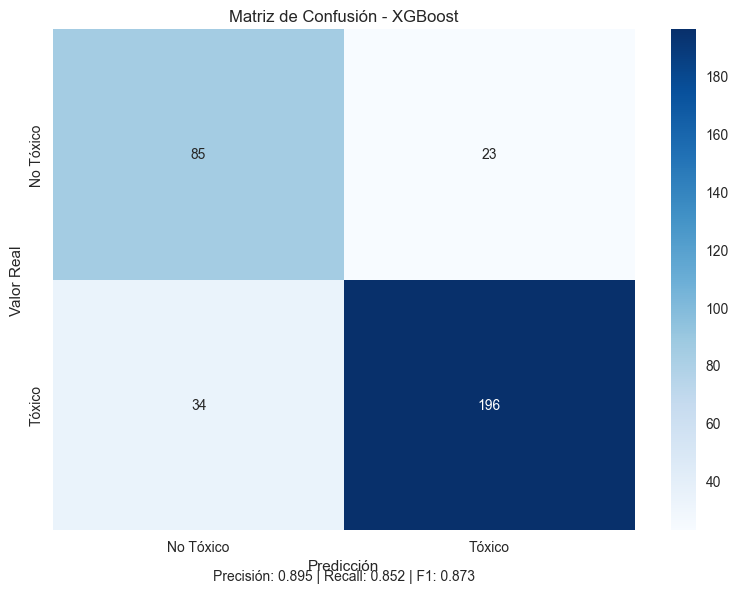

In [13]:
print("\n📊 EVALUACIÓN EN CONJUNTO DE PRUEBA:")

# Predicciones
y_pred = modelo.predict(X_test_vec)
y_pred_proba = modelo.predict_proba(X_test_vec)[:, 1]

# Métricas
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n🎯 Métricas principales:")
print(f"   - Accuracy: {accuracy:.3f}")
print(f"   - F1-Score: {f1:.3f}")

# Reporte completo
print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Tóxico', 'Tóxico'],
                          digits=3))

# Matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tóxico', 'Tóxico'],
            yticklabels=['No Tóxico', 'Tóxico'])
plt.title('Matriz de Confusión - XGBoost')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')

# Agregar métricas en el título
tn, fp, fn, tp = cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
plt.text(0.5, -0.1, f'Precisión: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}', 
         ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# 12. Análisis de importancia de features


🔤 ANÁLISIS DE IMPORTANCIA DE FEATURES:

🏆 Top 20 features más importantes:
   'fuck': 0.0231
   'drug': 0.0155
   'shit': 0.0132
   'looting': 0.0124
   'many': 0.0121
   'fucking': 0.0118
   'idiotic': 0.0109
   'thug': 0.0108
   'white people': 0.0100
   'video': 0.0099
   'peggy': 0.0098
   'dumb': 0.0098
   'black': 0.0096
   'shoot': 0.0093
   'stupid': 0.0093
   'idiot': 0.0091
   'truth': 0.0089
   'as': 0.0089
   'look': 0.0086
   'moron': 0.0083


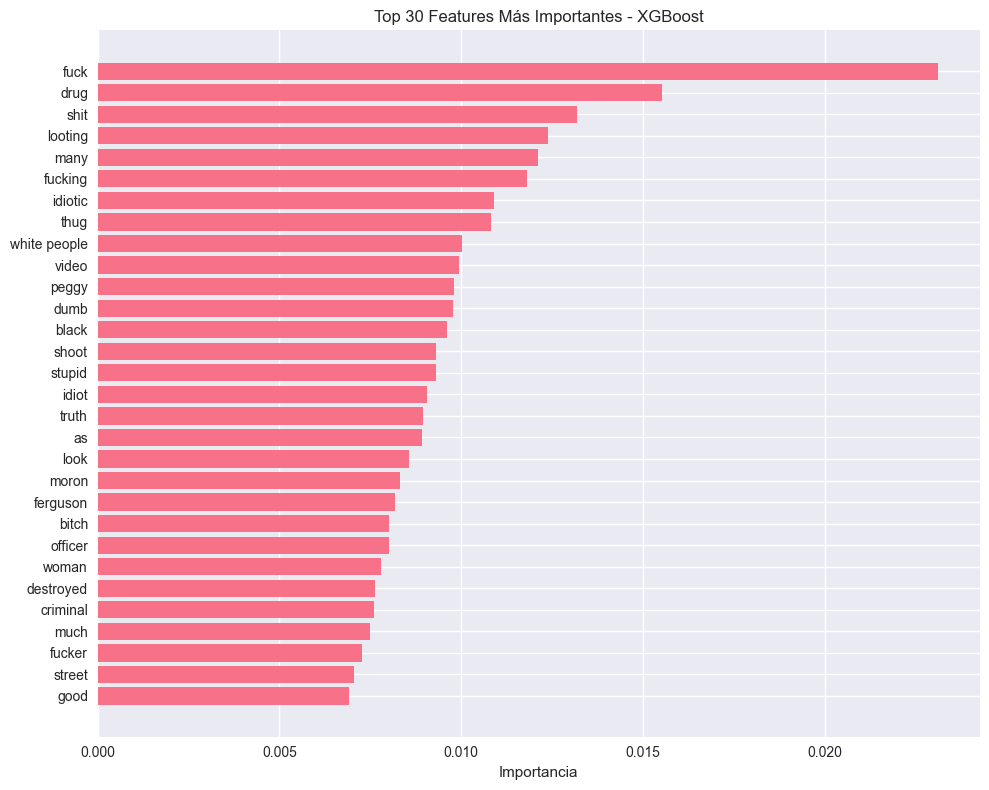


📊 Análisis detallado de importancia:

WEIGHT:
   'people': 87.0000
   'black': 54.0000
   'cop': 43.0000
   'police': 42.0000
   'brown': 41.0000
   'shot': 41.0000
   'would': 34.0000
   'get': 32.0000
   'white': 32.0000
   'fuck': 31.0000

GAIN:
   'fuck': 7.7077
   'drug': 5.1754
   'shit': 4.4004
   'looting': 4.1287
   'many': 4.0352
   'fucking': 3.9371
   'idiotic': 3.6336
   'thug': 3.6062
   'white people': 3.3371
   'video': 3.3148

COVER:
   'fuck': 136.6673
   'fucking': 129.9660
   'fucker': 129.2859
   'idiotic': 128.2896
   'dumb': 127.9565
   'bullshit': 127.8534
   'glad': 127.2351
   'stupid': 126.8835
   'deserved': 125.9599
   'cunt': 125.5732


In [14]:
print("\n🔤 ANÁLISIS DE IMPORTANCIA DE FEATURES:")

# Obtener importancia de features de XGBoost
feature_names = vectorizer.get_feature_names_out()
importancias = modelo.feature_importances_

# Crear DataFrame de importancias
df_importancia = pd.DataFrame({
    'feature': feature_names,
    'importance': importancias
}).sort_values('importance', ascending=False)

# Top 20 features más importantes
print("\n🏆 Top 20 features más importantes:")
for idx, row in df_importancia.head(20).iterrows():
    print(f"   '{row['feature']}': {row['importance']:.4f}")

# Visualizar importancia de features
plt.figure(figsize=(10, 8))
top_features = df_importancia.head(30)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 30 Features Más Importantes - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Análisis adicional: Gain vs Cover
if hasattr(modelo, 'get_booster'):
    print("\n📊 Análisis detallado de importancia:")
    importance_types = ['weight', 'gain', 'cover']
    
    for imp_type in importance_types:
        importances_dict = modelo.get_booster().get_score(importance_type=imp_type)
        if importances_dict:
            print(f"\n{imp_type.upper()}:")
            sorted_imp = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)[:10]
            for feat, score in sorted_imp:
                if feat.startswith('f'):
                    feat_idx = int(feat[1:])
                    feat_name = feature_names[feat_idx]
                    print(f"   '{feat_name}': {score:.4f}")

# 13. Función de predicción

In [15]:
def predecir_toxicidad(texto, modelo=modelo, vectorizer=vectorizer):
    """
    Predice si un comentario es tóxico.
    
    Retorna:
    - etiqueta: 'TÓXICO' o 'NO TÓXICO'
    - confianza: probabilidad de la predicción
    """
    # Preprocesar
    texto_limpio = limpiar_texto(texto)
    texto_procesado = procesar_texto(texto_limpio)
    
    # Vectorizar
    texto_vec = vectorizer.transform([texto_procesado])
    
    # Predecir
    prediccion = modelo.predict(texto_vec)[0]
    probabilidad = modelo.predict_proba(texto_vec)[0, 1]
    
    etiqueta = "TÓXICO ⚠️" if prediccion == 1 else "NO TÓXICO ✅"
    confianza = probabilidad if prediccion == 1 else (1 - probabilidad)
    
    return etiqueta, confianza

# Probar con ejemplos
print("\n🧪 PRUEBAS CON COMENTARIOS NUEVOS:")

ejemplos = [
    "Great video, thanks for sharing!",
    "You're so stupid and ignorant",
    "I disagree with your opinion",
    "This is garbage content, delete it",
    "Interesting perspective, never thought about it that way"
]

for comentario in ejemplos:
    etiqueta, confianza = predecir_toxicidad(comentario)
    print(f"\n📝 '{comentario}'")
    print(f"   → {etiqueta} (Confianza: {confianza:.1%})")


🧪 PRUEBAS CON COMENTARIOS NUEVOS:

📝 'Great video, thanks for sharing!'
   → NO TÓXICO ✅ (Confianza: 92.0%)

📝 'You're so stupid and ignorant'
   → TÓXICO ⚠️ (Confianza: 72.9%)

📝 'I disagree with your opinion'
   → NO TÓXICO ✅ (Confianza: 61.6%)

📝 'This is garbage content, delete it'
   → NO TÓXICO ✅ (Confianza: 61.6%)

📝 'Interesting perspective, never thought about it that way'
   → NO TÓXICO ✅ (Confianza: 84.8%)


# 14. Análisis de overfitting


🔍 ANÁLISIS DE OVERFITTING

📊 COMPARACIÓN DE MÉTRICAS POR CONJUNTO:
----------------------------------------

Entrenamiento:
  ACCURACY: 0.9163
  PRECISION: 0.9927
  RECALL: 0.8837
  F1: 0.9350
  AUC: 0.9875

Prueba:
  ACCURACY: 0.8314
  PRECISION: 0.8950
  RECALL: 0.8522
  F1: 0.8731
  AUC: 0.8764

🚨 DETECCIÓN DE OVERFITTING:
------------------------------
📈 F1 Train vs Test: 0.0620
⚠️  OVERFITTING MODERADO detectado (Train >> Test)

📊 GENERANDO VISUALIZACIONES...
📈 Calculando curvas de aprendizaje...


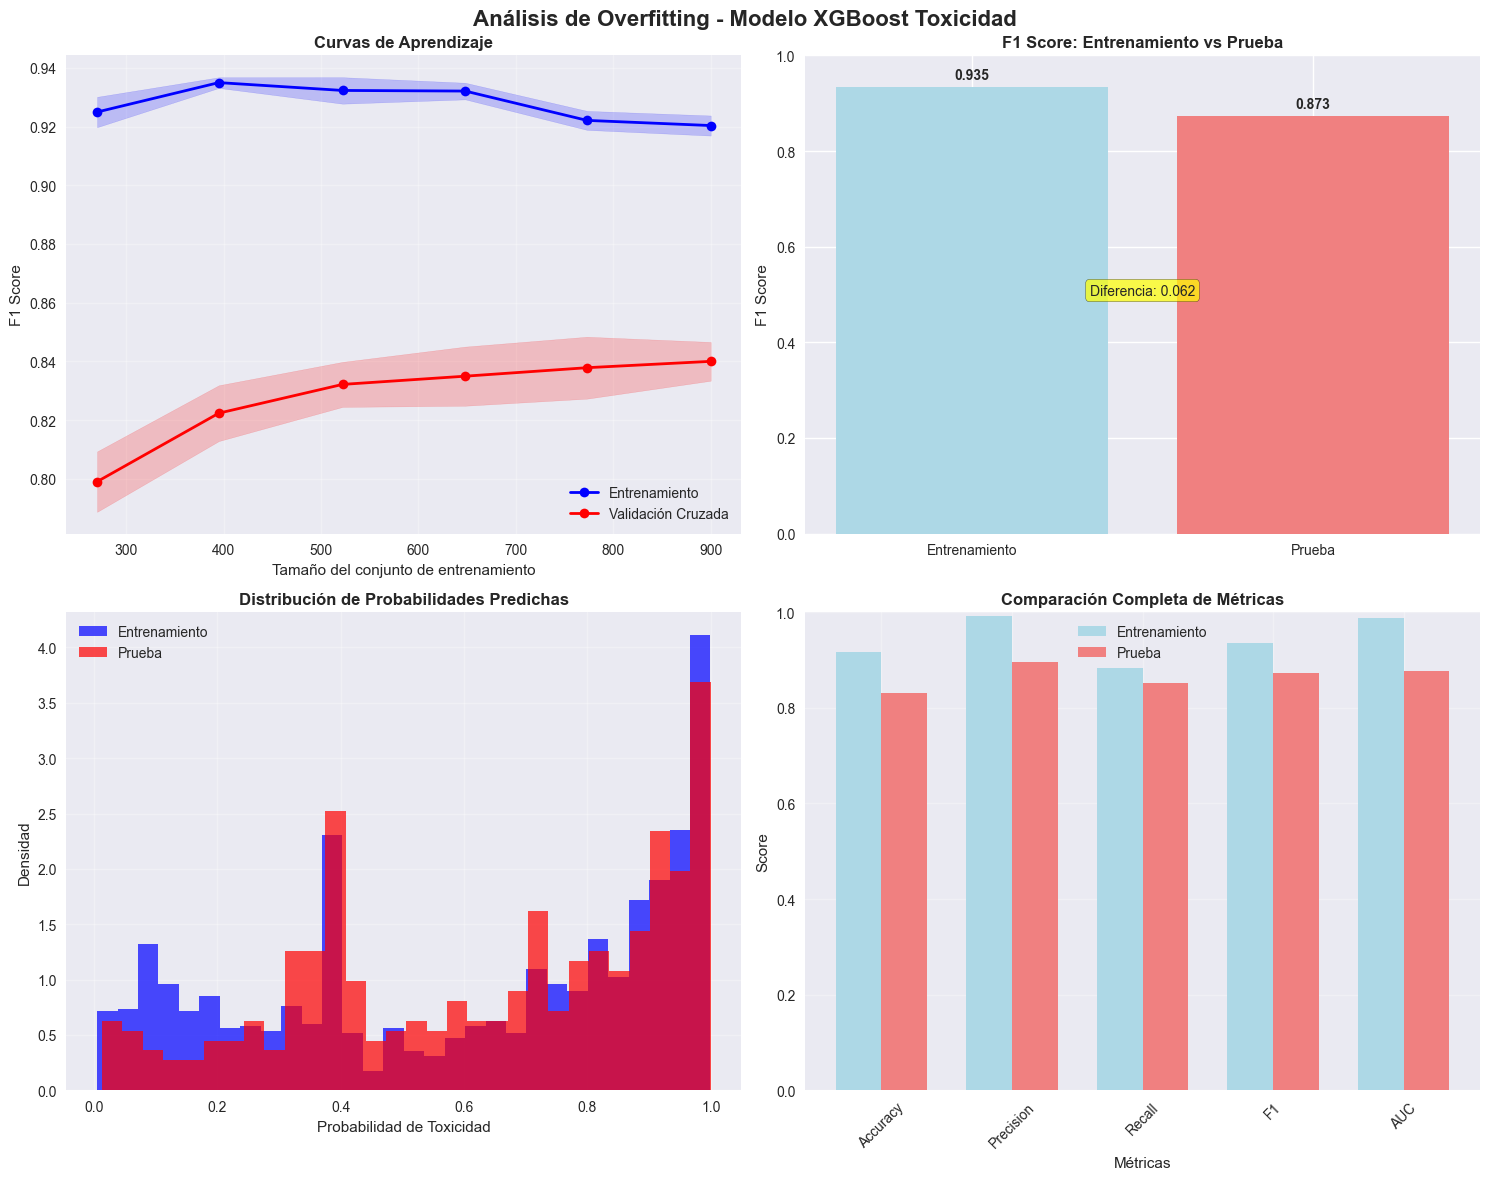


📋 REPORTE FINAL DE OVERFITTING
📊 ANÁLISIS DETALLADO:
   • F1 Entrenamiento: 0.9350
   • F1 Prueba:        0.8731

🔍 GAP DE RENDIMIENTO:
   • Train-Test gap:   0.0620

🩺 DIAGNÓSTICO:
   ⚠️  MODERADO: Overfitting detectado

💡 RECOMENDACIÓN:
   Considerar más regularización o early stopping más agresivo

🎯 CAPACIDAD DE GENERALIZACIÓN: 7.0/100 🟠
   👎 GENERALIZACIÓN BAJA - Hay overfitting, revisar modelo

🎯 ANÁLISIS ESPECÍFICO PARA TOXICIDAD:
   • Gap Precision: 0.0977
   • Gap Recall:    0.0315

✅ ANÁLISIS DE OVERFITTING COMPLETADO

📈 ANÁLISIS ADICIONAL: DISTRIBUCIÓN DE CONFIANZA
--------------------------------------------------
📊 Distribución de confianza en predicciones de prueba:
   • Alta confianza (>80% o <20%):  158 (46.7%)
   • Media confianza (60-80%, 20-40%): 135 (39.9%)
   • Baja confianza (40-60%):        45 (13.3%)

🎯 Accuracy por nivel de confianza:
   • Alta confianza: 0.949
   • Media confianza: 0.748
   • Baja confianza: 0.667

💡 Interpretación:
   ✅ Modelo hace prediccio

In [16]:
def analizar_overfitting(modelo_xgb, X_train_vec, y_train, X_test_vec, y_test):
    """
    Análisis completo de overfitting del modelo XGBoost
    Adaptado para el notebook de detección de toxicidad
    """
    
    print("🔍 ANÁLISIS DE OVERFITTING")
    print("=" * 50)
    
    # 1. MÉTRICAS COMPARATIVAS ENTRE CONJUNTOS
    print("\n📊 COMPARACIÓN DE MÉTRICAS POR CONJUNTO:")
    print("-" * 40)
    
    conjuntos_datos = {
        'Entrenamiento': (X_train_vec, y_train),
        'Prueba': (X_test_vec, y_test)
    }
    
    comparacion_metricas = {}
    
    for nombre, (X, y) in conjuntos_datos.items():
        y_pred = modelo_xgb.predict(X)
        y_proba = modelo_xgb.predict_proba(X)[:, 1]
        
        metricas = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'auc': roc_auc_score(y, y_proba)
        }
        
        comparacion_metricas[nombre] = metricas
        
        print(f"\n{nombre}:")
        for metrica, valor in metricas.items():
            print(f"  {metrica.upper()}: {valor:.4f}")
    
    # 2. DETECTAR OVERFITTING
    print(f"\n🚨 DETECCIÓN DE OVERFITTING:")
    print("-" * 30)
    
    train_f1 = comparacion_metricas['Entrenamiento']['f1']
    test_f1 = comparacion_metricas['Prueba']['f1']
    
    # Diferencias
    train_test_diff = train_f1 - test_f1
    
    print(f"📈 F1 Train vs Test: {train_test_diff:.4f}")
    
    # Análisis de overfitting
    overfitting_detectado = False
    
    if train_test_diff > 0.08:  # Más de 8% de diferencia es preocupante
        print("❌ OVERFITTING SEVERO detectado (Train >> Test)")
        overfitting_detectado = True
    elif train_test_diff > 0.05:  # Más de 5% de diferencia
        print("⚠️  OVERFITTING MODERADO detectado (Train >> Test)")
        overfitting_detectado = True
    elif train_test_diff > 0.02:  # Ligero overfitting
        print("⚠️  LIGERO OVERFITTING detectado")
        overfitting_detectado = True
    
    if not overfitting_detectado:
        print("✅ NO se detecta overfitting significativo")
        print("✅ Modelo tiene buena generalización")
    
    return comparacion_metricas

def graficar_analisis_overfitting(modelo_xgb, X_train_vec, y_train, X_test_vec, y_test, comparacion_metricas):
    """
    Visualizaciones para análisis de overfitting
    Adaptado para el modelo XGBoost del notebook
    """
    
    print(f"\n📊 GENERANDO VISUALIZACIONES...")
    
    # Crear subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Análisis de Overfitting - Modelo XGBoost Toxicidad', fontsize=16, fontweight='bold')
    
    # Subplot 1: Curvas de aprendizaje
    print("📈 Calculando curvas de aprendizaje...")
    
    # Crear un modelo XGBoost sin early stopping para las curvas de aprendizaje
    modelo_sin_early_stopping = xgb.XGBClassifier(
        n_estimators=100,  # Menos árboles para ser más rápido
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1
        # NO incluir early_stopping_rounds aquí
    )
    
    train_sizes, train_scores, val_scores = learning_curve(
        modelo_sin_early_stopping, X_train_vec, y_train,
        cv=3, 
        train_sizes=np.linspace(0.3, 1.0, 6),  # Empezar con más datos para evitar problemas
        scoring='f1',
        n_jobs=-1
    )
    
    # Calcular medias y desviaciones
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    axes[0, 0].plot(train_sizes, train_mean, 'o-', color='blue', label='Entrenamiento', linewidth=2)
    axes[0, 0].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
    
    axes[0, 0].plot(train_sizes, val_mean, 'o-', color='red', label='Validación Cruzada', linewidth=2)
    axes[0, 0].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')
    
    axes[0, 0].set_xlabel('Tamaño del conjunto de entrenamiento')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_title('Curvas de Aprendizaje', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Subplot 2: Comparación de métricas Train vs Test
    conjuntos = ['Entrenamiento', 'Prueba']
    f1_scores = [
        comparacion_metricas['Entrenamiento']['f1'],
        comparacion_metricas['Prueba']['f1']
    ]
    
    colores = ['lightblue', 'lightcoral']
    barras = axes[0, 1].bar(conjuntos, f1_scores, color=colores)
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('F1 Score: Entrenamiento vs Prueba', fontweight='bold')
    axes[0, 1].set_ylim(0, 1)
    
    # Añadir valores en las barras
    for barra, score in zip(barras, f1_scores):
        axes[0, 1].text(barra.get_x() + barra.get_width()/2, barra.get_height() + 0.01,
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Línea de referencia para mostrar la diferencia
    diferencia = abs(f1_scores[0] - f1_scores[1])
    axes[0, 1].text(0.5, 0.5, f'Diferencia: {diferencia:.3f}', 
                   transform=axes[0, 1].transAxes, ha='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    # Subplot 3: Distribución de probabilidades por conjunto
    y_proba_train = modelo_xgb.predict_proba(X_train_vec)[:, 1]
    y_proba_test = modelo_xgb.predict_proba(X_test_vec)[:, 1]
    
    axes[1, 0].hist(y_proba_train, bins=30, alpha=0.7, label='Entrenamiento', color='blue', density=True)
    axes[1, 0].hist(y_proba_test, bins=30, alpha=0.7, label='Prueba', color='red', density=True)
    axes[1, 0].set_xlabel('Probabilidad de Toxicidad')
    axes[1, 0].set_ylabel('Densidad')
    axes[1, 0].set_title('Distribución de Probabilidades Predichas', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Subplot 4: Todas las métricas comparadas
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
    train_metricas = [comparacion_metricas['Entrenamiento'][m.lower()] for m in metricas]
    test_metricas = [comparacion_metricas['Prueba'][m.lower()] for m in metricas]
    
    x = np.arange(len(metricas))
    ancho = 0.35
    
    axes[1, 1].bar(x - ancho/2, train_metricas, ancho, label='Entrenamiento', color='lightblue')
    axes[1, 1].bar(x + ancho/2, test_metricas, ancho, label='Prueba', color='lightcoral')
    
    axes[1, 1].set_xlabel('Métricas')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Comparación Completa de Métricas', fontweight='bold')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(metricas, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

def generar_reporte_overfitting(comparacion_metricas):
    """
    Generar reporte final de overfitting
    """
    
    print(f"\n📋 REPORTE FINAL DE OVERFITTING")
    print("=" * 50)
    
    train_f1 = comparacion_metricas['Entrenamiento']['f1']
    test_f1 = comparacion_metricas['Prueba']['f1']
    
    # Análisis detallado
    print(f"📊 ANÁLISIS DETALLADO:")
    print(f"   • F1 Entrenamiento: {train_f1:.4f}")
    print(f"   • F1 Prueba:        {test_f1:.4f}")
    
    gap_train_test = train_f1 - test_f1
    
    print(f"\n🔍 GAP DE RENDIMIENTO:")
    print(f"   • Train-Test gap:   {gap_train_test:.4f}")
    
    # Diagnóstico
    print(f"\n🩺 DIAGNÓSTICO:")
    
    if gap_train_test < 0.02:
        print("   ✅ EXCELENTE: Modelo muy bien generalizado")
        recomendacion = "El modelo está listo para producción"
        color_estado = "🟢"
        
    elif gap_train_test < 0.05:
        print("   ✅ BUENO: Ligero overfitting, pero aceptable")
        recomendacion = "Modelo aceptable para producción con monitoreo"
        color_estado = "🟡"
        
    elif gap_train_test < 0.08:
        print("   ⚠️  MODERADO: Overfitting detectado")
        recomendacion = "Considerar más regularización o early stopping más agresivo"
        color_estado = "🟠"
        
    else:
        print("   ❌ SEVERO: Overfitting significativo")
        recomendacion = "Necesario ajustar hiperparámetros o reentrenar"
        color_estado = "🔴"
    
    print(f"\n💡 RECOMENDACIÓN:")
    print(f"   {recomendacion}")
    
    # Métricas de generalización (no "confianza" para evitar confusión)
    puntaje_generalizacion = max(0, 100 - (gap_train_test * 100 * 15))
    print(f"\n🎯 CAPACIDAD DE GENERALIZACIÓN: {puntaje_generalizacion:.1f}/100 {color_estado}")
    
    if puntaje_generalizacion >= 85:
        print("   🏆 EXCELENTE generalización - Modelo muy robusto")
    elif puntaje_generalizacion >= 70:
        print("   👍 BUENA generalización - Modelo confiable")
    elif puntaje_generalizacion >= 50:
        print("   ⚠️  GENERALIZACIÓN MEDIA - Modelo aceptable con reservas")
    else:
        print("   👎 GENERALIZACIÓN BAJA - Hay overfitting, revisar modelo")
    
    # Análisis adicional específico para detección de toxicidad
    print(f"\n🎯 ANÁLISIS ESPECÍFICO PARA TOXICIDAD:")
    
    train_precision = comparacion_metricas['Entrenamiento']['precision']
    test_precision = comparacion_metricas['Prueba']['precision']
    precision_gap = train_precision - test_precision
    
    train_recall = comparacion_metricas['Entrenamiento']['recall']
    test_recall = comparacion_metricas['Prueba']['recall']
    recall_gap = train_recall - test_recall
    
    print(f"   • Gap Precision: {precision_gap:.4f}")
    print(f"   • Gap Recall:    {recall_gap:.4f}")
    
    if precision_gap > 0.1:
        print("   ⚠️  Modelo podría estar generando muchos falsos positivos en producción")
    if recall_gap > 0.1:
        print("   ⚠️  Modelo podría estar perdiendo comentarios tóxicos en producción")

# EJECUTAR ANÁLISIS COMPLETO DE OVERFITTING
# 1. Analizar overfitting con las métricas
comparacion_metricas = analizar_overfitting(
    modelo, X_train_vec, y_train, X_test_vec, y_test
)

# 2. Generar visualizaciones
graficar_analisis_overfitting(
    modelo, X_train_vec, y_train, X_test_vec, y_test, comparacion_metricas
)

# 3. Generar reporte final
generar_reporte_overfitting(comparacion_metricas)

print(f"\n✅ ANÁLISIS DE OVERFITTING COMPLETADO")
print("="*70)

# ANÁLISIS ADICIONAL: PREDICCIONES POR CONFIANZA
print(f"\n📈 ANÁLISIS ADICIONAL: DISTRIBUCIÓN DE CONFIANZA")
print("-" * 50)

# Analizar las predicciones por nivel de confianza
y_proba_test = modelo.predict_proba(X_test_vec)[:, 1]

# Categorizar predicciones por confianza
alta_confianza = (y_proba_test >= 0.8) | (y_proba_test <= 0.2)
media_confianza = ((y_proba_test >= 0.6) & (y_proba_test < 0.8)) | ((y_proba_test > 0.2) & (y_proba_test <= 0.4))
baja_confianza = (y_proba_test > 0.4) & (y_proba_test < 0.6)

print(f"📊 Distribución de confianza en predicciones de prueba:")
print(f"   • Alta confianza (>80% o <20%):  {alta_confianza.sum():3d} ({alta_confianza.mean()*100:.1f}%)")
print(f"   • Media confianza (60-80%, 20-40%): {media_confianza.sum():3d} ({media_confianza.mean()*100:.1f}%)")
print(f"   • Baja confianza (40-60%):       {baja_confianza.sum():3d} ({baja_confianza.mean()*100:.1f}%)")

# Calcular accuracy por nivel de confianza
if alta_confianza.sum() > 0:
    acc_alta = accuracy_score(y_test[alta_confianza], (y_proba_test[alta_confianza] > 0.5))
    print(f"\n🎯 Accuracy por nivel de confianza:")
    print(f"   • Alta confianza: {acc_alta:.3f}")

if media_confianza.sum() > 0:
    acc_media = accuracy_score(y_test[media_confianza], (y_proba_test[media_confianza] > 0.5))
    print(f"   • Media confianza: {acc_media:.3f}")

if baja_confianza.sum() > 0:
    acc_baja = accuracy_score(y_test[baja_confianza], (y_proba_test[baja_confianza] > 0.5))
    print(f"   • Baja confianza: {acc_baja:.3f}")

print(f"\n💡 Interpretación:")
if baja_confianza.mean() < 0.15:  # Menos del 15% de predicciones inciertas
    print("   ✅ Modelo hace predicciones con alta certeza individual")
    print("   📊 La mayoría de predicciones son muy seguras (>80% o <20%)")
else:
    print("   ⚠️  Considerable número de predicciones con baja certeza")
    print("   📊 Muchas predicciones están en zona gris (40-60%)")

print(f"\n🏁 ANÁLISIS COMPLETO FINALIZADO")
print("="*70)

# 15. Optimización con Optuna

In [23]:
def objective(trial):
    """Función objetivo para optimizar hiperparámetros anti-overfitting"""
    try:
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
        
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 8),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.7, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 5.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
            'objective': 'binary:logistic',
            'eval_metric': ['error', 'logloss'],  
            'use_label_encoder': False,  
            'random_state': 42,
            'n_jobs': 1,  # Usar 1 core para evitar conflictos en CV
            'scale_pos_weight': scale_pos_weight,
            'verbosity': 0
        }
        
        # Modelo para validación cruzada
        modelo_cv = xgb.XGBClassifier(**params)
        
        # Validación cruzada
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  
        f1_scores = cross_val_score(
            modelo_cv, X_train_vec, y_train, 
            cv=cv, scoring='f1', error_score='raise'
        )
        
        modelo_test = xgb.XGBClassifier(**params)
        modelo_test.fit(X_train_vec, y_train)
        
        train_f1 = f1_score(y_train, modelo_test.predict(X_train_vec))
        test_f1 = f1_score(y_test, modelo_test.predict(X_test_vec))
        overfitting_gap = abs(train_f1 - test_f1)
        
        train_pred_proba = modelo_test.predict_proba(X_train_vec)[:, 1]
        test_pred_proba = modelo_test.predict_proba(X_test_vec)[:, 1]
        
        from sklearn.metrics import log_loss
        train_logloss = log_loss(y_train, train_pred_proba)
        test_logloss = log_loss(y_test, test_pred_proba)
        logloss_gap = abs(train_logloss - test_logloss)
        
        # Guardar métricas
        trial.set_user_attr('cv_f1', f1_scores.mean())
        trial.set_user_attr('cv_f1_std', f1_scores.std())
        trial.set_user_attr('train_f1', train_f1)
        trial.set_user_attr('test_f1', test_f1)
        trial.set_user_attr('overfitting_gap', overfitting_gap)
        trial.set_user_attr('train_logloss', train_logloss)
        trial.set_user_attr('test_logloss', test_logloss)
        trial.set_user_attr('logloss_gap', logloss_gap)
        
        # Optimiza F1 pero penaliza overfitting en ambas métricas
        penalty = (overfitting_gap * 1.0) + (logloss_gap * 0.5)
        return f1_scores.mean() - penalty
        
    except Exception as e:
        print(f"Error en trial: {e}")
        return -1.0  # Score muy bajo para trials fallidos

def optimizar_xgboost(X_train_vec, y_train, X_test_vec, y_test, n_trials=50):
    """Optimiza hiperparámetros usando Optuna"""
    # Hacer variables globales para objective
    globals().update({
        'X_train_vec': X_train_vec, 'y_train': y_train,
        'X_test_vec': X_test_vec, 'y_test': y_test
    })
    
    # Verificar que los datos sean válidos
    print(f"Datos de entrenamiento: {X_train_vec.shape}, {len(y_train)}")
    print(f"Datos de prueba: {X_test_vec.shape}, {len(y_test)}")
    print(f"Distribución y_train: {np.bincount(y_train)}")
    
    study = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=42)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    # Filtrar trials exitosos
    successful_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and t.value > -0.5]
    
    if not successful_trials:
        raise ValueError("No se completaron trials exitosos. Revisa tus datos.")
    
    best_trial = max(successful_trials, key=lambda x: x.value)
    
    print(f"\nMejor score: {best_trial.value:.4f}")
    print(f"CV F1: {best_trial.user_attrs['cv_f1']:.4f} (±{best_trial.user_attrs['cv_f1_std']:.4f})")
    print(f"Train F1: {best_trial.user_attrs['train_f1']:.4f}")
    print(f"Test F1: {best_trial.user_attrs['test_f1']:.4f}")
    print(f"Gap overfitting F1: {best_trial.user_attrs['overfitting_gap']:.4f}")
    print(f"Train LogLoss: {best_trial.user_attrs['train_logloss']:.4f}")  # NUEVO
    print(f"Test LogLoss: {best_trial.user_attrs['test_logloss']:.4f}")    # NUEVO
    print(f"Gap overfitting LogLoss: {best_trial.user_attrs['logloss_gap']:.4f}")  # NUEVO
    print(f"Trials exitosos: {len(successful_trials)}/{len(study.trials)}")
    
    return best_trial.params

def entrenar_modelo_final(best_params, X_train_vec, y_train, X_test_vec, y_test):
    """Entrena modelo final con parámetros optimizados - VERSIÓN CORREGIDA"""
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    
    final_params = {
        **best_params,
        'objective': 'binary:logistic',
        'eval_metric': ['error', 'logloss'],  
        'use_label_encoder': False,           
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': scale_pos_weight,
        'verbosity': 0
    }
    
    modelo = xgb.XGBClassifier(**final_params)
    modelo.fit(X_train_vec, y_train)
    
    # Evaluación final
    train_pred = modelo.predict(X_train_vec)
    test_pred = modelo.predict(X_test_vec)
    
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    
    # Añadir evaluación de logloss como en modelo original
    train_pred_proba = modelo.predict_proba(X_train_vec)[:, 1]
    test_pred_proba = modelo.predict_proba(X_test_vec)[:, 1]
    
    from sklearn.metrics import log_loss
    train_logloss = log_loss(y_train, train_pred_proba)
    test_logloss = log_loss(y_test, test_pred_proba)
    
    # Validación cruzada final
    cv_scores = cross_val_score(
        xgb.XGBClassifier(**final_params), 
        X_train_vec, y_train, 
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), 
        scoring='f1'
    )
    
    print(f"\n✅ Modelo final:")
    print(f"Train F1: {train_f1:.4f}")
    print(f"Test F1: {test_f1:.4f}")
    print(f"CV F1: {cv_scores.mean():.3f} (±{cv_scores.std() * 2:.3f})")
    print(f"Overfitting gap F1: {abs(train_f1 - test_f1):.4f}")
    print(f"Train LogLoss: {train_logloss:.4f}")     
    print(f"Test LogLoss: {test_logloss:.4f}")      
    print(f"Overfitting gap LogLoss: {abs(train_logloss - test_logloss):.4f}") 
    
    return modelo, final_params

def optimizar_y_entrenar(X_train_vec, y_train, X_test_vec, y_test, n_trials=50):
    """Proceso completo de optimización y entrenamiento"""
    print("🚀 Optimizando XGBoost con Optuna...")
    
    # Verificaciones iniciales
    if len(np.unique(y_train)) != 2:
        raise ValueError("y_train debe ser binario (0 y 1)")
    
    if X_train_vec.shape[0] != len(y_train):
        raise ValueError("X_train_vec y y_train deben tener el mismo número de filas")
    
    best_params = optimizar_xgboost(X_train_vec, y_train, X_test_vec, y_test, n_trials)
    modelo_final, final_params = entrenar_modelo_final(best_params, X_train_vec, y_train, X_test_vec, y_test)
    
    return modelo_final, final_params

def guardar_modelos(modelo, vectorizer, nombre_base="modelo_toxicidad_xgboost"):
    """Guarda el modelo y vectorizer en archivos pickle"""
    import pickle
    
    # Nombres de archivos
    nombre_modelo = f"../final_model/{nombre_base}_final.pkl"
    nombre_vectorizer = f"../final_model/vectorizer_toxicidad_final.pkl"
    
    try:
        # Guardar modelo
        with open(nombre_modelo, 'wb') as f:
            pickle.dump(modelo, f)
        
        # Guardar vectorizer
        with open(nombre_vectorizer, 'wb') as f:
            pickle.dump(vectorizer, f)
        
        print(f"✅ Archivos guardados exitosamente:")
        print(f"   - {nombre_modelo}")
        print(f"   - {nombre_vectorizer}")
        
        return True
        
    except Exception as e:
        print(f"❌ Error al guardar archivos: {e}")
        return False

try:
    # Ejecutar optimización
    modelo_optimizado, params_optimizados = optimizar_y_entrenar(
        X_train_vec, y_train, X_test_vec, y_test, n_trials=60  
    )
    
    # Mostrar mejores parámetros
    print("\n🔧 MEJORES PARÁMETROS ENCONTRADOS:")
    for param, valor in params_optimizados.items():
        if param not in ['objective', 'eval_metric', 'use_label_encoder', 'random_state', 'n_jobs', 'scale_pos_weight', 'verbosity']:
            if isinstance(valor, float):
                print(f"   {param}: {valor:.4f}")
            else:
                print(f"   {param}: {valor}")
    
    print(f"\n🎯 Optimización completada exitosamente!")
    
    # Guardar modelos   
    if 'vectorizer' in globals():
        guardar_modelos(modelo_optimizado, vectorizer)
    else:
        print("⚠️  Advertencia: 'vectorizer' no está definido. Solo guardando el modelo.")
        import pickle
        with open('../final_model/modelo_toxicidad_xgboost_final.pkl', 'wb') as f:
            pickle.dump(modelo_optimizado, f)
        print("✅ Modelo guardado: ../final_model/modelo_toxicidad_xgboost_final.pkl")
    
except Exception as e:
    print(f"❌ Error durante la optimización: {e}")
    print("\n🔍 Verificando datos...")
    
    # Diagnóstico de datos
    print(f"Forma X_train_vec: {X_train_vec.shape if 'X_train_vec' in globals() else 'No definido'}")
    print(f"Forma y_train: {y_train.shape if 'y_train' in globals() else 'No definido'}")
    print(f"Forma X_test_vec: {X_test_vec.shape if 'X_test_vec' in globals() else 'No definido'}")
    print(f"Forma y_test: {y_test.shape if 'y_test' in globals() else 'No definido'}")
    
    if 'y_train' in globals():
        print(f"Valores únicos en y_train: {np.unique(y_train)}")
        print(f"Distribución y_train: {np.bincount(y_train)}")
    
    if 'X_train_vec' in globals():
        print(f"Tipo X_train_vec: {type(X_train_vec)}")
        print(f"¿Hay NaN en X_train_vec?: {np.isnan(X_train_vec).any() if hasattr(X_train_vec, 'shape') else 'No es array'}")
    
    print("\n💡 Sugerencias:")
    print("1. Asegúrate de que y_train e y_test contengan solo 0s y 1s")
    print("2. Verifica que no hay valores NaN en los datos")
    print("3. Confirma que X_train_vec y y_train tienen el mismo número de filas")

[I 2025-07-09 08:51:00,300] A new study created in memory with name: no-name-fb8153de-e0ad-4fbe-931d-553dd416acff


🚀 Optimizando XGBoost con Optuna...
Datos de entrenamiento: (1350, 2000), 1350
Datos de prueba: (338, 2000), 338
Distribución y_train: [430 920]


  0%|          | 0/60 [00:00<?, ?it/s]

Best trial: 0. Best value: 0.481442:   2%|▏         | 1/60 [00:02<02:38,  2.69s/it]

[I 2025-07-09 08:51:02,987] Trial 0 finished with value: 0.4814422094879258 and parameters: {'n_estimators': 144, 'max_depth': 8, 'learning_rate': 0.22227824312530747, 'subsample': 0.8197316968394073, 'colsample_bytree': 0.7312037280884873, 'reg_alpha': 0.7884126564776512, 'reg_lambda': 0.29983722471931534, 'min_child_weight': 7}. Best is trial 0 with value: 0.4814422094879258.


Best trial: 1. Best value: 0.645108:   3%|▎         | 2/60 [00:09<04:43,  4.88s/it]

[I 2025-07-09 08:51:09,411] Trial 1 finished with value: 0.6451079623527693 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01596950334578271, 'subsample': 0.8939819704323989, 'colsample_bytree': 0.8664885281600844, 'reg_alpha': 1.0695721622845982, 'reg_lambda': 0.9173065863634321, 'min_child_weight': 2}. Best is trial 1 with value: 0.6451079623527693.


Best trial: 1. Best value: 0.645108:   5%|▌         | 3/60 [00:12<03:53,  4.09s/it]

[I 2025-07-09 08:51:12,545] Trial 2 finished with value: 0.5937914097186059 and parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.13526405540621358, 'subsample': 0.7582458280396084, 'colsample_bytree': 0.8223705789444758, 'reg_alpha': 0.7060743646536888, 'reg_lambda': 1.4678017961907386, 'min_child_weight': 3}. Best is trial 1 with value: 0.6451079623527693.


Best trial: 3. Best value: 0.655788:   7%|▋         | 4/60 [00:17<04:07,  4.41s/it]

[I 2025-07-09 08:51:17,463] Trial 3 finished with value: 0.6557881002165266 and parameters: {'n_estimators': 164, 'max_depth': 7, 'learning_rate': 0.06790539682592432, 'subsample': 0.8028468876827223, 'colsample_bytree': 0.8184829137724084, 'reg_alpha': 0.24178755947278865, 'reg_lambda': 3.0416488109881774, 'min_child_weight': 2}. Best is trial 3 with value: 0.6557881002165266.


Best trial: 3. Best value: 0.655788:   8%|▊         | 5/60 [00:19<03:17,  3.60s/it]

[I 2025-07-09 08:51:19,606] Trial 4 finished with value: 0.5616435832416062 and parameters: {'n_estimators': 66, 'max_depth': 8, 'learning_rate': 0.2900332895916222, 'subsample': 0.8616794696232922, 'colsample_bytree': 0.7609227538346741, 'reg_alpha': 0.49738384889185555, 'reg_lambda': 3.424322802295663, 'min_child_weight': 4}. Best is trial 3 with value: 0.6557881002165266.


Best trial: 3. Best value: 0.655788:  10%|█         | 6/60 [00:21<02:43,  3.02s/it]

[I 2025-07-09 08:51:21,503] Trial 5 finished with value: 0.4793487549490985 and parameters: {'n_estimators': 80, 'max_depth': 5, 'learning_rate': 0.019972671123413333, 'subsample': 0.8818640804157565, 'colsample_bytree': 0.7517559963200033, 'reg_alpha': 3.31598619892637, 'reg_lambda': 1.5654382696861608, 'min_child_weight': 4}. Best is trial 3 with value: 0.6557881002165266.


Best trial: 3. Best value: 0.655788:  12%|█▏        | 7/60 [00:24<02:38,  2.99s/it]

[I 2025-07-09 08:51:24,450] Trial 6 finished with value: 0.4475536028370067 and parameters: {'n_estimators': 187, 'max_depth': 4, 'learning_rate': 0.291179542051722, 'subsample': 0.8550265646722229, 'colsample_bytree': 0.8878997883128379, 'reg_alpha': 4.475188478633967, 'reg_lambda': 2.9935208942673146, 'min_child_weight': 7}. Best is trial 3 with value: 0.6557881002165266.


Best trial: 3. Best value: 0.655788:  13%|█▎        | 8/60 [00:25<02:07,  2.46s/it]

[I 2025-07-09 08:51:25,770] Trial 7 finished with value: 0.4732346962558295 and parameters: {'n_estimators': 72, 'max_depth': 4, 'learning_rate': 0.023115913784056037, 'subsample': 0.7650660661526528, 'colsample_bytree': 0.7777354579378963, 'reg_alpha': 1.3640316685517406, 'reg_lambda': 4.145400170668127, 'min_child_weight': 3}. Best is trial 3 with value: 0.6557881002165266.


Best trial: 3. Best value: 0.655788:  15%|█▌        | 9/60 [00:28<02:16,  2.68s/it]

[I 2025-07-09 08:51:28,916] Trial 8 finished with value: 0.5935192788333612 and parameters: {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.050868025242681164, 'subsample': 0.8604393961508079, 'colsample_bytree': 0.7149101287359542, 'reg_alpha': 4.934565813636581, 'reg_lambda': 3.8635013987903206, 'min_child_weight': 2}. Best is trial 3 with value: 0.6557881002165266.


Best trial: 9. Best value: 0.676352:  17%|█▋        | 10/60 [00:30<02:06,  2.53s/it]

[I 2025-07-09 08:51:31,116] Trial 9 finished with value: 0.6763522317419174 and parameters: {'n_estimators': 51, 'max_depth': 7, 'learning_rate': 0.21498862971580895, 'subsample': 0.8458014336081975, 'colsample_bytree': 0.8542540693371892, 'reg_alpha': 0.3794828121531109, 'reg_lambda': 1.7987439854359204, 'min_child_weight': 1}. Best is trial 9 with value: 0.6763522317419174.


Best trial: 9. Best value: 0.676352:  18%|█▊        | 11/60 [00:35<02:34,  3.15s/it]

[I 2025-07-09 08:51:35,684] Trial 10 finished with value: 0.6449298392250084 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.19602204373030296, 'subsample': 0.7035923751229639, 'colsample_bytree': 0.8508276320352263, 'reg_alpha': 2.102197780118566, 'reg_lambda': 4.799256022267647, 'min_child_weight': 1}. Best is trial 9 with value: 0.6763522317419174.


Best trial: 11. Best value: 0.679088:  20%|██        | 12/60 [00:43<03:49,  4.79s/it]

[I 2025-07-09 08:51:44,211] Trial 11 finished with value: 0.679087566778677 and parameters: {'n_estimators': 246, 'max_depth': 7, 'learning_rate': 0.11581912737159866, 'subsample': 0.8117049461558581, 'colsample_bytree': 0.8169390504181222, 'reg_alpha': 0.19388797232626265, 'reg_lambda': 2.3041216023881286, 'min_child_weight': 1}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  22%|██▏       | 13/60 [00:54<05:03,  6.47s/it]

[I 2025-07-09 08:51:54,541] Trial 12 finished with value: 0.6753324881039717 and parameters: {'n_estimators': 251, 'max_depth': 7, 'learning_rate': 0.126333738678572, 'subsample': 0.8280805115091064, 'colsample_bytree': 0.8371621355131391, 'reg_alpha': 1.9658812213152084, 'reg_lambda': 2.0852650412620504, 'min_child_weight': 1}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  23%|██▎       | 14/60 [00:59<04:47,  6.24s/it]

[I 2025-07-09 08:52:00,256] Trial 13 finished with value: 0.47412541248194107 and parameters: {'n_estimators': 225, 'max_depth': 7, 'learning_rate': 0.21376245340409436, 'subsample': 0.7746703753377896, 'colsample_bytree': 0.7974120044300607, 'reg_alpha': 0.024798016852605298, 'reg_lambda': 2.1962695357807607, 'min_child_weight': 6}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  25%|██▌       | 15/60 [01:15<06:44,  8.98s/it]

[I 2025-07-09 08:52:15,587] Trial 14 finished with value: 0.6693967869968951 and parameters: {'n_estimators': 278, 'max_depth': 8, 'learning_rate': 0.10054813141741378, 'subsample': 0.8289347370536172, 'colsample_bytree': 0.8963577589845468, 'reg_alpha': 2.6781678213815296, 'reg_lambda': 2.6129644902172666, 'min_child_weight': 1}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  27%|██▋       | 16/60 [01:25<06:50,  9.32s/it]

[I 2025-07-09 08:52:25,712] Trial 15 finished with value: 0.6011074964112318 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.17205158908256118, 'subsample': 0.7877091874581011, 'colsample_bytree': 0.8646829098257841, 'reg_alpha': 1.4100048121640958, 'reg_lambda': 1.1298991934109122, 'min_child_weight': 3}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  28%|██▊       | 17/60 [01:30<05:46,  8.07s/it]

[I 2025-07-09 08:52:30,857] Trial 16 finished with value: 0.5581262600769348 and parameters: {'n_estimators': 220, 'max_depth': 5, 'learning_rate': 0.24701520448205433, 'subsample': 0.8431581035764005, 'colsample_bytree': 0.797346005351761, 'reg_alpha': 3.416026505819999, 'reg_lambda': 0.033653197068915564, 'min_child_weight': 5}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  30%|███       | 18/60 [01:36<05:07,  7.32s/it]

[I 2025-07-09 08:52:36,426] Trial 17 finished with value: 0.6741595580679637 and parameters: {'n_estimators': 102, 'max_depth': 7, 'learning_rate': 0.17312872853734904, 'subsample': 0.7366066005700881, 'colsample_bytree': 0.8205477165544802, 'reg_alpha': 1.714334973728107, 'reg_lambda': 1.7983675211048042, 'min_child_weight': 1}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  32%|███▏      | 19/60 [01:44<05:07,  7.51s/it]

[I 2025-07-09 08:52:44,377] Trial 18 finished with value: 0.6527521272397627 and parameters: {'n_estimators': 159, 'max_depth': 8, 'learning_rate': 0.09727796163465106, 'subsample': 0.8078545557829264, 'colsample_bytree': 0.8658729381647328, 'reg_alpha': 2.595564053683059, 'reg_lambda': 0.5736499949514333, 'min_child_weight': 2}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  33%|███▎      | 20/60 [01:51<05:02,  7.56s/it]

[I 2025-07-09 08:52:52,062] Trial 19 finished with value: 0.5601870588868942 and parameters: {'n_estimators': 233, 'max_depth': 6, 'learning_rate': 0.24349122155064257, 'subsample': 0.879480454232574, 'colsample_bytree': 0.842049406995436, 'reg_alpha': 0.17571070265671274, 'reg_lambda': 2.562213467333089, 'min_child_weight': 4}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  35%|███▌      | 21/60 [01:57<04:30,  6.94s/it]

[I 2025-07-09 08:52:57,563] Trial 20 finished with value: 0.5036731453098549 and parameters: {'n_estimators': 206, 'max_depth': 5, 'learning_rate': 0.15374072825847263, 'subsample': 0.7402727241845766, 'colsample_bytree': 0.7829027034147106, 'reg_alpha': 0.9240586802084657, 'reg_lambda': 1.132515558430249, 'min_child_weight': 5}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  37%|███▋      | 22/60 [02:15<06:30, 10.28s/it]

[I 2025-07-09 08:53:15,636] Trial 21 finished with value: 0.6744666011832301 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.12403603379775707, 'subsample': 0.833038499399334, 'colsample_bytree': 0.8387221311801631, 'reg_alpha': 1.8204159234889126, 'reg_lambda': 2.0268020836384513, 'min_child_weight': 1}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  38%|███▊      | 23/60 [02:24<06:11, 10.03s/it]

[I 2025-07-09 08:53:25,077] Trial 22 finished with value: 0.663531693147955 and parameters: {'n_estimators': 249, 'max_depth': 7, 'learning_rate': 0.10847197777597802, 'subsample': 0.8166436477928161, 'colsample_bytree': 0.8259549513560531, 'reg_alpha': 2.9892529284468057, 'reg_lambda': 2.1491266304502243, 'min_child_weight': 1}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  40%|████      | 24/60 [02:38<06:38, 11.06s/it]

[I 2025-07-09 08:53:38,554] Trial 23 finished with value: 0.6422354174783771 and parameters: {'n_estimators': 296, 'max_depth': 8, 'learning_rate': 0.08116583845950041, 'subsample': 0.7939629668550541, 'colsample_bytree': 0.875805713684565, 'reg_alpha': 1.1844789501710566, 'reg_lambda': 2.4010629926392704, 'min_child_weight': 2}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  42%|████▏     | 25/60 [02:47<06:11, 10.61s/it]

[I 2025-07-09 08:53:48,090] Trial 24 finished with value: 0.6652303555793088 and parameters: {'n_estimators': 252, 'max_depth': 6, 'learning_rate': 0.14497310483343057, 'subsample': 0.8435987917248688, 'colsample_bytree': 0.8497875549595323, 'reg_alpha': 0.5686867759120497, 'reg_lambda': 1.7005720120440775, 'min_child_weight': 1}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  43%|████▎     | 26/60 [02:50<04:36,  8.14s/it]

[I 2025-07-09 08:53:50,464] Trial 25 finished with value: 0.6274333419602236 and parameters: {'n_estimators': 54, 'max_depth': 7, 'learning_rate': 0.17602060107078935, 'subsample': 0.8258429843887719, 'colsample_bytree': 0.8327764773283013, 'reg_alpha': 3.7579303724022397, 'reg_lambda': 2.952992048057309, 'min_child_weight': 2}. Best is trial 11 with value: 0.679087566778677.


Best trial: 11. Best value: 0.679088:  45%|████▌     | 27/60 [03:04<05:26,  9.88s/it]

[I 2025-07-09 08:54:04,405] Trial 26 finished with value: 0.5923735749184377 and parameters: {'n_estimators': 269, 'max_depth': 7, 'learning_rate': 0.2654525322037734, 'subsample': 0.7836821755971501, 'colsample_bytree': 0.8079437272516471, 'reg_alpha': 2.019848920008067, 'reg_lambda': 3.4405681911795174, 'min_child_weight': 3}. Best is trial 11 with value: 0.679087566778677.


Best trial: 27. Best value: 0.690508:  47%|████▋     | 28/60 [03:15<05:30, 10.32s/it]

[I 2025-07-09 08:54:15,747] Trial 27 finished with value: 0.6905084590805624 and parameters: {'n_estimators': 185, 'max_depth': 6, 'learning_rate': 0.11959770478869339, 'subsample': 0.8421865791099464, 'colsample_bytree': 0.8529902371557576, 'reg_alpha': 0.3758289594933393, 'reg_lambda': 1.2750313538773375, 'min_child_weight': 1}. Best is trial 27 with value: 0.6905084590805624.


Best trial: 27. Best value: 0.690508:  48%|████▊     | 29/60 [03:24<05:12, 10.08s/it]

[I 2025-07-09 08:54:25,257] Trial 28 finished with value: 0.6532592187301886 and parameters: {'n_estimators': 180, 'max_depth': 6, 'learning_rate': 0.19414383053922218, 'subsample': 0.8722192562286515, 'colsample_bytree': 0.8857973800123112, 'reg_alpha': 0.3938402994354214, 'reg_lambda': 0.73156910982345, 'min_child_weight': 2}. Best is trial 27 with value: 0.6905084590805624.


Best trial: 27. Best value: 0.690508:  50%|█████     | 30/60 [03:32<04:39,  9.31s/it]

[I 2025-07-09 08:54:32,800] Trial 29 finished with value: 0.6554432625720118 and parameters: {'n_estimators': 141, 'max_depth': 5, 'learning_rate': 0.053430020197603845, 'subsample': 0.8108725303540043, 'colsample_bytree': 0.8553989271307461, 'reg_alpha': 0.8288693494552506, 'reg_lambda': 1.1952643274340333, 'min_child_weight': 1}. Best is trial 27 with value: 0.6905084590805624.


Best trial: 27. Best value: 0.690508:  52%|█████▏    | 31/60 [03:36<03:39,  7.59s/it]

[I 2025-07-09 08:54:36,345] Trial 30 finished with value: 0.5039670665890905 and parameters: {'n_estimators': 89, 'max_depth': 6, 'learning_rate': 0.2183896630630182, 'subsample': 0.8410018109632658, 'colsample_bytree': 0.8074369259641774, 'reg_alpha': 0.06279125737248481, 'reg_lambda': 0.39302440054797105, 'min_child_weight': 6}. Best is trial 27 with value: 0.6905084590805624.


Best trial: 27. Best value: 0.690508:  53%|█████▎    | 32/60 [03:54<05:03, 10.84s/it]

[I 2025-07-09 08:54:54,781] Trial 31 finished with value: 0.6829511852390334 and parameters: {'n_estimators': 235, 'max_depth': 8, 'learning_rate': 0.12090555637624346, 'subsample': 0.8183272810175117, 'colsample_bytree': 0.8411817915321468, 'reg_alpha': 0.5955654471779414, 'reg_lambda': 1.9712314686945045, 'min_child_weight': 1}. Best is trial 27 with value: 0.6905084590805624.


Best trial: 32. Best value: 0.691259:  55%|█████▌    | 33/60 [04:11<05:38, 12.54s/it]

[I 2025-07-09 08:55:11,300] Trial 32 finished with value: 0.6912588695334649 and parameters: {'n_estimators': 204, 'max_depth': 8, 'learning_rate': 0.11047909546305835, 'subsample': 0.8986137442211625, 'colsample_bytree': 0.8751073879394247, 'reg_alpha': 0.6224522790116744, 'reg_lambda': 1.4258832988346022, 'min_child_weight': 1}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  57%|█████▋    | 34/60 [04:23<05:23, 12.45s/it]

[I 2025-07-09 08:55:23,530] Trial 33 finished with value: 0.6564413202885759 and parameters: {'n_estimators': 210, 'max_depth': 8, 'learning_rate': 0.11436710014364007, 'subsample': 0.8847195290805118, 'colsample_bytree': 0.879994271073615, 'reg_alpha': 0.7925212664248826, 'reg_lambda': 1.466431294344224, 'min_child_weight': 2}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  58%|█████▊    | 35/60 [04:35<05:06, 12.27s/it]

[I 2025-07-09 08:55:35,383] Trial 34 finished with value: 0.6626556940640236 and parameters: {'n_estimators': 193, 'max_depth': 8, 'learning_rate': 0.0707849273370958, 'subsample': 0.8996993375098842, 'colsample_bytree': 0.8704296511401409, 'reg_alpha': 1.1211441872385117, 'reg_lambda': 1.281498892556172, 'min_child_weight': 2}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  60%|██████    | 36/60 [04:46<04:45, 11.91s/it]

[I 2025-07-09 08:55:46,442] Trial 35 finished with value: 0.6796153643728101 and parameters: {'n_estimators': 160, 'max_depth': 8, 'learning_rate': 0.13845018344264062, 'subsample': 0.8004092115795374, 'colsample_bytree': 0.8983641500804903, 'reg_alpha': 0.6225790148432403, 'reg_lambda': 0.8569508441557897, 'min_child_weight': 1}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  62%|██████▏   | 37/60 [04:53<04:04, 10.62s/it]

[I 2025-07-09 08:55:54,047] Trial 36 finished with value: 0.6006621595992485 and parameters: {'n_estimators': 142, 'max_depth': 8, 'learning_rate': 0.13702687103244168, 'subsample': 0.8002505663761252, 'colsample_bytree': 0.8959318047395658, 'reg_alpha': 1.5356615432975897, 'reg_lambda': 0.9030620440326845, 'min_child_weight': 3}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  63%|██████▎   | 38/60 [05:08<04:23, 11.97s/it]

[I 2025-07-09 08:56:09,180] Trial 37 finished with value: 0.6603714797870905 and parameters: {'n_estimators': 165, 'max_depth': 8, 'learning_rate': 0.09144798991030227, 'subsample': 0.8710064986041965, 'colsample_bytree': 0.8622063719548526, 'reg_alpha': 0.6449092052672465, 'reg_lambda': 0.8192161870647898, 'min_child_weight': 2}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  65%|██████▌   | 39/60 [05:21<04:12, 12.04s/it]

[I 2025-07-09 08:56:21,390] Trial 38 finished with value: 0.6653217963240238 and parameters: {'n_estimators': 164, 'max_depth': 8, 'learning_rate': 0.15805675841061143, 'subsample': 0.7532095021588108, 'colsample_bytree': 0.8867451125280857, 'reg_alpha': 1.2430370170481468, 'reg_lambda': 0.2360053022759614, 'min_child_weight': 1}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  67%|██████▋   | 40/60 [05:29<03:38, 10.94s/it]

[I 2025-07-09 08:56:29,745] Trial 39 finished with value: 0.6234303816611477 and parameters: {'n_estimators': 195, 'max_depth': 4, 'learning_rate': 0.08327146468856624, 'subsample': 0.8553367458744225, 'colsample_bytree': 0.8966164035955496, 'reg_alpha': 0.9172724137373263, 'reg_lambda': 0.44171953368919903, 'min_child_weight': 3}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  68%|██████▊   | 41/60 [05:41<03:34, 11.30s/it]

[I 2025-07-09 08:56:41,903] Trial 40 finished with value: 0.648131731253334 and parameters: {'n_estimators': 177, 'max_depth': 8, 'learning_rate': 0.054279439363011855, 'subsample': 0.7759924996562827, 'colsample_bytree': 0.877388750551498, 'reg_alpha': 0.4096703055217878, 'reg_lambda': 1.5183203363704925, 'min_child_weight': 2}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  70%|███████   | 42/60 [06:00<04:01, 13.44s/it]

[I 2025-07-09 08:57:00,333] Trial 41 finished with value: 0.6779655647277535 and parameters: {'n_estimators': 239, 'max_depth': 8, 'learning_rate': 0.12134615210295445, 'subsample': 0.8198390711614583, 'colsample_bytree': 0.8279046941542167, 'reg_alpha': 0.5987322169425884, 'reg_lambda': 1.8709704330941506, 'min_child_weight': 1}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  72%|███████▏  | 43/60 [06:14<03:55, 13.85s/it]

[I 2025-07-09 08:57:15,152] Trial 42 finished with value: 0.6734984304273782 and parameters: {'n_estimators': 214, 'max_depth': 7, 'learning_rate': 0.13153635946737083, 'subsample': 0.8013800997760978, 'colsample_bytree': 0.8115024686690513, 'reg_alpha': 0.21423713098606906, 'reg_lambda': 1.3754033204834357, 'min_child_weight': 1}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  73%|███████▎  | 44/60 [06:25<03:25, 12.82s/it]

[I 2025-07-09 08:57:25,552] Trial 43 finished with value: 0.6712853171072138 and parameters: {'n_estimators': 122, 'max_depth': 8, 'learning_rate': 0.10894966453529684, 'subsample': 0.8150292845026803, 'colsample_bytree': 0.844182565632589, 'reg_alpha': 0.9775475968676188, 'reg_lambda': 0.9916640411645352, 'min_child_weight': 1}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  75%|███████▌  | 45/60 [06:41<03:29, 13.98s/it]

[I 2025-07-09 08:57:42,239] Trial 44 finished with value: 0.6791879269556811 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.14567357077142906, 'subsample': 0.7954034933379521, 'colsample_bytree': 0.7002900023585507, 'reg_alpha': 0.33265002869267113, 'reg_lambda': 2.773302668526368, 'min_child_weight': 1}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 32. Best value: 0.691259:  77%|███████▋  | 46/60 [06:52<02:59, 12.84s/it]

[I 2025-07-09 08:57:52,415] Trial 45 finished with value: 0.6462623439158659 and parameters: {'n_estimators': 187, 'max_depth': 8, 'learning_rate': 0.14271595363532244, 'subsample': 0.786585066104903, 'colsample_bytree': 0.7349603632391747, 'reg_alpha': 2.335118710941883, 'reg_lambda': 2.7398394361666036, 'min_child_weight': 2}. Best is trial 32 with value: 0.6912588695334649.


Best trial: 46. Best value: 0.696236:  78%|███████▊  | 47/60 [07:00<02:29, 11.52s/it]

[I 2025-07-09 08:58:00,861] Trial 46 finished with value: 0.6962355402496334 and parameters: {'n_estimators': 152, 'max_depth': 7, 'learning_rate': 0.15406811623784217, 'subsample': 0.7702854070137191, 'colsample_bytree': 0.7056131199801108, 'reg_alpha': 0.42189464291417245, 'reg_lambda': 3.5433108077551547, 'min_child_weight': 1}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  80%|████████  | 48/60 [07:10<02:12, 11.02s/it]

[I 2025-07-09 08:58:10,694] Trial 47 finished with value: 0.6912209025394814 and parameters: {'n_estimators': 152, 'max_depth': 7, 'learning_rate': 0.18591937772686737, 'subsample': 0.761003800963107, 'colsample_bytree': 0.7431247300345507, 'reg_alpha': 0.6589003255387823, 'reg_lambda': 4.1565160321573105, 'min_child_weight': 1}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  82%|████████▏ | 49/60 [07:17<01:49,  9.99s/it]

[I 2025-07-09 08:58:18,286] Trial 48 finished with value: 0.6667400300866861 and parameters: {'n_estimators': 131, 'max_depth': 6, 'learning_rate': 0.18924968718654359, 'subsample': 0.7586802417422991, 'colsample_bytree': 0.7437703930632522, 'reg_alpha': 1.5180119920440518, 'reg_lambda': 4.39459512001904, 'min_child_weight': 1}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  83%|████████▎ | 50/60 [07:24<01:30,  9.00s/it]

[I 2025-07-09 08:58:24,988] Trial 49 finished with value: 0.64252821594913 and parameters: {'n_estimators': 152, 'max_depth': 7, 'learning_rate': 0.16245704361200272, 'subsample': 0.7172759588154163, 'colsample_bytree': 0.7150554264010921, 'reg_alpha': 0.7429617174559692, 'reg_lambda': 3.5377162564791664, 'min_child_weight': 2}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  85%|████████▌ | 51/60 [07:30<01:13,  8.13s/it]

[I 2025-07-09 08:58:31,076] Trial 50 finished with value: 0.5688909913752647 and parameters: {'n_estimators': 169, 'max_depth': 6, 'learning_rate': 0.18456625468113255, 'subsample': 0.7474960779571018, 'colsample_bytree': 0.7635428432014749, 'reg_alpha': 4.135452335787115, 'reg_lambda': 4.773294575897112, 'min_child_weight': 4}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  87%|████████▋ | 52/60 [07:37<01:01,  7.68s/it]

[I 2025-07-09 08:58:37,727] Trial 51 finished with value: 0.6875426054678111 and parameters: {'n_estimators': 112, 'max_depth': 8, 'learning_rate': 0.20214180756945477, 'subsample': 0.7695548308131368, 'colsample_bytree': 0.7207762337181984, 'reg_alpha': 0.5338965839557603, 'reg_lambda': 3.992354879090631, 'min_child_weight': 1}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  88%|████████▊ | 53/60 [07:44<00:53,  7.62s/it]

[I 2025-07-09 08:58:45,184] Trial 52 finished with value: 0.6858467407685668 and parameters: {'n_estimators': 131, 'max_depth': 7, 'learning_rate': 0.20585792365086159, 'subsample': 0.7698049939150231, 'colsample_bytree': 0.7216564849531198, 'reg_alpha': 0.3934398029003177, 'reg_lambda': 3.9537952127948297, 'min_child_weight': 1}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  90%|█████████ | 54/60 [07:51<00:43,  7.27s/it]

[I 2025-07-09 08:58:51,658] Trial 53 finished with value: 0.6898086103473045 and parameters: {'n_estimators': 104, 'max_depth': 7, 'learning_rate': 0.20302030911365285, 'subsample': 0.7687337350425435, 'colsample_bytree': 0.7201797131298657, 'reg_alpha': 0.09464036711687707, 'reg_lambda': 3.8560481945416263, 'min_child_weight': 1}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  92%|█████████▏| 55/60 [07:57<00:35,  7.01s/it]

[I 2025-07-09 08:58:58,054] Trial 54 finished with value: 0.6753429404392821 and parameters: {'n_estimators': 111, 'max_depth': 7, 'learning_rate': 0.23179958559785405, 'subsample': 0.7650971935895438, 'colsample_bytree': 0.7063131271410971, 'reg_alpha': 0.016064539952065082, 'reg_lambda': 3.6475892343451433, 'min_child_weight': 1}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  93%|█████████▎| 56/60 [08:00<00:23,  5.78s/it]

[I 2025-07-09 08:59:00,969] Trial 55 finished with value: 0.4989449965108837 and parameters: {'n_estimators': 103, 'max_depth': 7, 'learning_rate': 0.20545838904460081, 'subsample': 0.7765714247595339, 'colsample_bytree': 0.7274926693813735, 'reg_alpha': 1.0561338093942303, 'reg_lambda': 4.278168164606826, 'min_child_weight': 7}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  95%|█████████▌| 57/60 [08:03<00:15,  5.03s/it]

[I 2025-07-09 08:59:04,237] Trial 56 finished with value: 0.6539838504561131 and parameters: {'n_estimators': 76, 'max_depth': 6, 'learning_rate': 0.22974674540756015, 'subsample': 0.7543635279527658, 'colsample_bytree': 0.7394368180820318, 'reg_alpha': 0.23985147885231808, 'reg_lambda': 4.020591398027851, 'min_child_weight': 2}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 46. Best value: 0.696236:  97%|█████████▋| 58/60 [08:13<00:12,  6.33s/it]

[I 2025-07-09 08:59:13,595] Trial 57 finished with value: 0.6931906699866692 and parameters: {'n_estimators': 149, 'max_depth': 7, 'learning_rate': 0.16664077236265395, 'subsample': 0.7359897926934227, 'colsample_bytree': 0.7494746896636189, 'reg_alpha': 0.4647494020499443, 'reg_lambda': 3.209889646319806, 'min_child_weight': 1}. Best is trial 46 with value: 0.6962355402496334.


Best trial: 58. Best value: 0.69902:  98%|█████████▊| 59/60 [08:17<00:05,  5.62s/it] 

[I 2025-07-09 08:59:17,576] Trial 58 finished with value: 0.699019974105157 and parameters: {'n_estimators': 153, 'max_depth': 3, 'learning_rate': 0.16825647039945402, 'subsample': 0.7311888907371801, 'colsample_bytree': 0.7512648946632007, 'reg_alpha': 0.24484416326675046, 'reg_lambda': 3.26673659636646, 'min_child_weight': 1}. Best is trial 58 with value: 0.699019974105157.


Best trial: 58. Best value: 0.69902: 100%|██████████| 60/60 [08:21<00:00,  8.35s/it]


[I 2025-07-09 08:59:21,321] Trial 59 finished with value: 0.537103873070632 and parameters: {'n_estimators': 147, 'max_depth': 3, 'learning_rate': 0.16526533510118352, 'subsample': 0.7239402072711106, 'colsample_bytree': 0.7497933620340459, 'reg_alpha': 0.793340496234477, 'reg_lambda': 3.2043330686531712, 'min_child_weight': 5}. Best is trial 58 with value: 0.699019974105157.

Mejor score: 0.6990
CV F1: 0.7822 (±0.0138)
Train F1: 0.8530
Test F1: 0.8077
Gap overfitting F1: 0.0453
Train LogLoss: 0.4187
Test LogLoss: 0.4946
Gap overfitting LogLoss: 0.0758
Trials exitosos: 60/60

✅ Modelo final:
Train F1: 0.8488
Test F1: 0.7883
CV F1: 0.767 (±0.027)
Overfitting gap F1: 0.0605
Train LogLoss: 0.4163
Test LogLoss: 0.4943
Overfitting gap LogLoss: 0.0780

🔧 MEJORES PARÁMETROS ENCONTRADOS:
   n_estimators: 153
   max_depth: 3
   learning_rate: 0.1683
   subsample: 0.7312
   colsample_bytree: 0.7513
   reg_alpha: 0.2448
   reg_lambda: 3.2667
   min_child_weight: 1

🎯 Optimización completada exito

# 16. Probar modelo optimizado con Optuna

In [28]:
def cargar_modelo():
    """Carga el modelo y vectorizer guardados"""
    try:
        with open('../final_model/modelo_toxicidad_xgboost_final.pkl', 'rb') as f:
            modelo = pickle.load(f)
        
        with open('../final_model/vectorizer_toxicidad_final.pkl', 'rb') as f:
            vectorizer = pickle.load(f)
        
        print("✅ Modelo y vectorizer cargados exitosamente")
        return modelo, vectorizer
        
    except FileNotFoundError as e:
        print(f"❌ Error: No se encontró el archivo {e}")
        return None, None
    except Exception as e:
        print(f"❌ Error al cargar modelo: {e}")
        return None, None

def probar_frase(modelo, vectorizer, frase):
    """
    Prueba una frase y devuelve si es tóxica o no
    
    Args:
        modelo: Modelo XGBoost entrenado
        vectorizer: Vectorizer entrenado
        frase: String con la frase a probar
    
    Returns:
        str: 'toxico' o 'no toxico'
    """
    try:
        # Vectorizar la frase
        frase_vectorizada = vectorizer.transform([frase])
        
        # Predecir
        prediccion = modelo.predict(frase_vectorizada)[0]
        
        # Convertir a texto
        return "toxico" if prediccion == 1 else "no toxico"
        
    except Exception as e:
        print(f"Error al procesar frase: {e}")
        return "error"

def probar_frases(modelo, vectorizer, frases):
    """
    Prueba múltiples frases
    
    Args:
        modelo: Modelo XGBoost entrenado
        vectorizer: Vectorizer entrenado
        frases: Lista de frases o string único
    
    Returns:
        Lista de diccionarios con frase y predicción
    """
    # Si es una sola frase, convertir a lista
    if isinstance(frases, str):
        frases = [frases]
    
    resultados = []
    
    for frase in frases:
        try:
            # Vectorizar
            frase_vectorizada = vectorizer.transform([frase])
            
            # Predecir
            prediccion = modelo.predict(frase_vectorizada)[0]
            probabilidad = modelo.predict_proba(frase_vectorizada)[0]
            
            # Confianza (probabilidad máxima)
            confianza = max(probabilidad)
            
            resultados.append({
                'frase': frase,
                'prediccion': "toxico" if prediccion == 1 else "no toxico",
                'confianza': round(confianza, 3),
                'prob_toxico': round(probabilidad[1], 3)
            })
            
        except Exception as e:
            resultados.append({
                'frase': frase,
                'prediccion': "error",
                'confianza': 0.0,
                'prob_toxico': 0.0
            })
    
    return resultados

def mostrar_resultados(resultados):
    """Muestra los resultados de forma legible"""
    print("\n=== RESULTADOS DE CLASIFICACIÓN ===")
    for r in resultados:
        if r['prediccion'] != 'error':
            print(f'"{r["frase"]}" -> {r["prediccion"]} (confianza: {r["confianza"]:.3f})')
        else:
            print(f'"{r["frase"]}" -> ERROR')

def clasificar_frases(frases):
    """
    Función todo-en-uno para clasificar frases
    
    Args:
        frases: String o lista de strings
    
    Returns:
        Lista de resultados
    """
    # Cargar modelo
    modelo, vectorizer = cargar_modelo()
    
    if modelo is None or vectorizer is None:
        return []
    
    resultados = probar_frases(modelo, vectorizer, frases)

    mostrar_resultados(resultados)
    
    return resultados

# EJEMPLO DE USO
if __name__ == "__main__":
    # Frases de prueba
    frases_test = [
        "you are stupid",
        "thank you very much",
        "this is amazing",
        "I hate you",
        "have a great day",
        "you suck",
        "this is wonderful"
    ]
    
    # Usar función principal
    resultados = clasificar_frases(frases_test)

# VERSIÓN SIMPLE
def es_toxico(frase):
    """Versión ultra simple que solo devuelve True/False"""
    modelo, vectorizer = cargar_modelo()
    if modelo and vectorizer:
        resultado = probar_frase(modelo, vectorizer, frase)
        return resultado == "toxico"
    return False

✅ Modelo y vectorizer cargados exitosamente



=== RESULTADOS DE CLASIFICACIÓN ===
"you are stupid" -> toxico (confianza: 0.698)
"thank you very much" -> no toxico (confianza: 0.748)
"this is amazing" -> no toxico (confianza: 0.564)
"I hate you" -> no toxico (confianza: 0.564)
"have a great day" -> no toxico (confianza: 0.564)
"you suck" -> no toxico (confianza: 0.564)
"this is wonderfulgo away" -> no toxico (confianza: 0.564)
"nobody likes you" -> no toxico (confianza: 0.564)
"you should leave" -> no toxico (confianza: 0.564)
"get out of here" -> no toxico (confianza: 0.579)
"you don't belong here" -> no toxico (confianza: 0.564)
"shut your mouth" -> no toxico (confianza: 0.564)
"mind your own business" -> no toxico (confianza: 0.564)
